In [1]:
# Simulate decaying correlation. 

In [15]:
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import geopandas as gpd

import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

from pyproj import Proj
from shapely.geometry import Point

## Load location data for industry p
Pass point coordinates to separate columns 'loc_x' and 'loc_y'.

Convert to metres (UTM, Easting Northing) so to have metrical units and work more confortably. However keep in mind there will be a little distortion

In [33]:
gpd.read_file('./locations_data/NG_point_1.shp').head()

,STATE,COUNTY,PLANT,ZIPCODE,STATUS,CAPACITY,geometry
0,CO,Weld,Redtail Gas Plant,80742,Active,20.0,POINT (-103.9806987444521 40.54616715790659)
1,AL,Mobile,Hatters Pond Gas Plant,36525,Active,70.0,POINT (-88.01355335527282 30.87934662953371)
2,TX,Scurry,Snyder Gasoline Plant,79549,Active,90.0,POINT (-100.6051852583855 33.02811065588871)
3,CO,Garfield,Hay Canyon Treating Facility,81524,Active,25.0,POINT (-108.9485560265749 39.20001702484542)
4,AL,Conecuh,Castleberry,36432,Active,9.0,POINT (-87.14239632743687 31.29116545735495)


In [77]:
# Either Natural Gas or Oil Refineries. Load and make a column called value.

industry_name = 'Natural Gas'
NG = gpd.read_file('./locations_data/NG_point_1.shp'); NG.crs = {'init': 'epsg:4326'}
NG['value'] = NG['CAPACITY']

industry_name = 'Oil Refineries'
OR = gpd.read_file('./locations_data/U.S._Petroleum_Refineries.shp')
OR['value'] = OR[[col for col in OR.columns if 'Mbpd' in col]].sum(1)
OR = OR.loc[~OR.State.isin(['Alaska', 'Hawaii'])] # Keep contiguous US

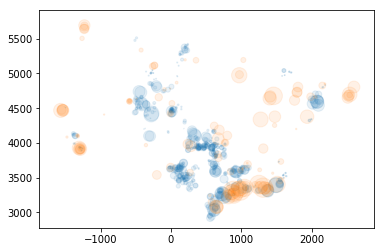

In [131]:
def groupby_grid(df, log10_size, x_col, y_col):
    grouped = df.groupby([df[x_col].round(-log10_size), df[y_col].round(-log10_size)])
    return grouped


dist = [.3, 1, 3, 6, 10, 20, 30, 50, 75, 100, 300, 500]  # distances (km) used in letting corr decay
D = len(dist)
N = 10

df_disc_list = []

n_grids = 2
n_industries = 2
for j in range(n_industries):
    
    indu_p = [NG, OR][j]
    industry_name = ['Natural Gas', 'Oil Refineries'][j]
    
    # Get coordinates in separate columns
    loc_values = np.array([(p.x, p.y) for p in indu_p.geometry])
    indu_p['loc_x'] = loc_values[:, 0]
    indu_p['loc_y'] = loc_values[:, 1]

    # Projection to UTM 14S (it's centered on US midwest).
    myProj = Proj("+proj=utm +zone=14S, +north +ellps=WGS84 +datum=WGS84 +units=m +no_defs")

    # Project
    indu_p['loc_x'], indu_p['loc_y'] = myProj(indu_p['loc_x'].values, indu_p['loc_y'].values)
    # Units from meters to km
    indu_p['loc_x']  = indu_p['loc_x']/1e3; 
    indu_p['loc_y']  = indu_p['loc_y']/1e3; 

    # Check what we got so far
    plt.scatter(indu_p['loc_x'], indu_p['loc_y'], s = indu_p['value']/5., alpha = .1)
    
    ### Create jittered Q industry locations
    # For industry q, copy industry p, and apply an increasing jitter. 
    indu_q = indu_p.copy()[['value', 'geometry']].reset_index(drop = True)
    
    cov_results = np.zeros((D, N))
    x_0 = indu_p['loc_x']
    y_0 = indu_p['loc_y']

    for d in range(D):
        # For each distance d
        for n in range(N):
            # For each repetition n. Set the name of the x, y columns. 
            x_col = 'loc_d'+str(d)+'n'+str(n)+'_x'
            y_col = 'loc_d'+str(d)+'n'+str(n)+'_y'

            # Random choose angle, shift original x, y by d.
            angles = np.pi * np.random.uniform(0, 2, len(indu_q))
            x_d = dist[d] * np.cos(angles); y_d = dist[d] * np.sin(angles)
            # jittered q locations to column
            jit_values = np.array([x_0, y_0]).T + np.array([x_d, y_d]).T

            indu_q[x_col] = jit_values[:, 0]
            indu_q[y_col] = jit_values[:, 1]
            
    for i in range(n_grids): # Artificial admin area grid size in logs
        grid_size = [1, 2][i]
        cov_results = np.zeros((D, N))
        for d in range(D):
            for n in range(N):
        #         print(d, n)
                x_col = 'loc_d'+str(d)+'n'+str(n)+'_x'
                y_col = 'loc_d'+str(d)+'n'+str(n)+'_y'
                indu_q_i = indu_q[['value', x_col, y_col]]
                indu_q_i['geometry'] = list(zip(indu_q_i[x_col], indu_q_i[y_col]))
                indu_q_i['geometry'] = indu_q_i['geometry'].apply(Point)
                indu_q_i = gpd.GeoDataFrame(indu_q_i)

                df = pd.concat([groupby_grid(indu_p, grid_size, 'loc_x', 'loc_y')[['value']].sum(), 
                                   groupby_grid(indu_q_i, grid_size, x_col, y_col)[['value']].sum()], axis = 1).fillna(0)
                normed = df/df.sum()
                dot = normed.iloc[:, 0].dot(normed.iloc[:, 1])
                #cosine, but it's a normalization, so that 

                cov_results[d, n] = np.log10(dot) - np.log10(sum(normed.iloc[:, 0]*normed.iloc[:, 0]))

        df_disc = pd.DataFrame(cov_results.mean(1), index = dist, columns=['mean'])
        df_disc.index.name = 'b_dist'
        df_disc['grid_size'] = np.power(10, grid_size) # in km
        df_disc['industry'] = industry_name

        df_disc_list += [df_disc]

plt.show()

result_discrete = pd.concat(df_disc_list)

In [132]:
# Test. One plant per county.
# indu_p = indu_p.groupby('AREA_FIPS').first().reset_index()

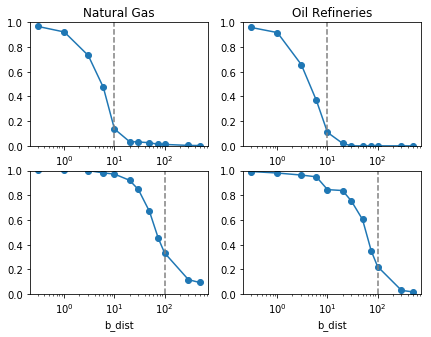

In [133]:
result_discrete = pd.concat(df_disc_list)

fig, axs = plt.subplots(n_industries, n_grids, figsize = (7, 5))

for j in range(result_discrete.industry.nunique()):
    indu = result_discrete.industry.unique()[j]
    for i in range(result_discrete.grid_size.nunique()):
        gs = result_discrete.grid_size.unique()[i]
        ax = axs[i][j]
        np.power(10, result_discrete.loc[(result_discrete.grid_size == gs) & (result_discrete.industry == indu)]['mean']
                ).plot(marker = 'o', ax = ax)
        ax.set_xscale('log')
        ax.set_ylim(0, 1)
        ax.axvline(gs, color = '.5', linestyle = '--')
        if i == 0: ax.set_title(indu)


In [94]:

fig, ax = plt.subplots(1, 1, figsize = (7, 5))

np.power(10, df_disc['mean']).plot(marker = 'o', ax = ax)
np.power(10, df_cont).T.plot(marker = '.', ax = ax)
plt.xscale('log')

# for b in range(B):
#     ax.axhline(np.log10(sum((indu_p['CAPACITY']/indu_p['CAPACITY'].sum())**2)) - np.log10(4*b), linestyle = '--')


,mean,grid_size,industry
b_dist,,,
1,-0.026670,10,Natural Gas
3,-0.141541,10,Natural Gas
6,-0.381360,10,Natural Gas
10,-0.819372,10,Natural Gas
30,-1.825282,10,Natural Gas
60,-1.970657,10,Natural Gas
100,-1.875616,10,Natural Gas
300,-2.829349,10,Natural Gas
500,-3.106222,10,Natural Gas


In [9]:
# def flap(x, y, t, b, xm, ym):
#     print(np.sqrt((x-xm)**2 + (y-ym)**2)/b < 5) 
#     if (abs(x-xm) < 5*b) and (abs(y-ym) < 5*b):
#         i = t*np.exp(-np.sqrt((x-xm)**2 + (y-ym)**2)/b)/(2*b)
#     else:
#         i = 0
#     return i

import numexpr as ne

def flap(x, y, t, b, xm, ym):
    w = np.sqrt((x-xm)**2 + (y-ym)**2)
    return t*ne.evaluate('exp(-w/b)/(2*b)')

x_min = indu_q[[col for col in indu_q.columns if '_x' in col]].min().min()
x_max = indu_q[[col for col in indu_q.columns if '_x' in col]].max().max()
y_min = indu_q[[col for col in indu_q.columns if '_y' in col]].min().min()
y_max = indu_q[[col for col in indu_q.columns if '_y' in col]].max().max()

def sum_pdfs(df, x = np.arange(x_min, x_max, 2), y = np.arange(y_min, y_max, 2)): # grid every 500 mts
    xx, yy = np.meshgrid(x, y, sparse=True)
    z_cum = np.zeros((len(y), len(x)))
    for v in df.values[:3]:
        z = flap(xx, yy, v[0], v[1], v[2], v[3])
        z_cum = z_cum + z
    return z_cum


In [10]:
# z_cump = sum_pdfs(industry_p[['CAPACITY', 'b', 'x', 'y']])
# h = plt.contourf(x,y,z_cump)
# plt.show()

widths = np.array([10, 30, 60]) # influence radios in km

B = len(widths)
# N = 3
int_results = np.zeros((B, D, N))

for d in range(D):
    for n in range(N):
        x_col = 'loc_d'+str(d)+'n'+str(n)+'_x'
        y_col = 'loc_d'+str(d)+'n'+str(n)+'_y'
        print(d, n)

        for b in range(B):
            indu_p['b'] = widths[b]
            indu_q['b'] = widths[b]

            z_cump = sum_pdfs(indu_p[['CAPACITY', 'b', 'loc_x', 'loc_y']])
            z_cumq = sum_pdfs(indu_q[['CAPACITY', 'b', x_col, y_col]])
            z_cump = z_cump/sum(sum(z_cump))
            z_cumq = z_cumq/sum(sum(z_cumq))
            
#             dot_list += [sum(sum(z_cump * z_cumq))] # == np.dot(z_cump.flatten(), z_cumq.flatten())
#             cov_list += [np.cov(z_cump.flatten(), z_cumq.flatten())[1, 0]]
#             h = plt.contourf(x,y,z_cump * z_cumq)
#             plt.show()
            
#             dot = np.vstack([widths, np.log10(dot_list)]).T
#             print()
            int_results[b, d, n] = np.log10(sum(sum(z_cump * z_cumq))) - np.log10(sum(sum(z_cump * z_cump)))

0 0
0 1
0 2
1 0
1 1
1 2
2 0
2 1
2 2
3 0
3 1
3 2
4 0
4 1
4 2
5 0
5 1
5 2
6 0
6 1
6 2


In [11]:
df_cont = pd.DataFrame(int_results.mean(-1), columns = dist, index = widths)


In [52]:
df_disc

,mean,grid_size,industry
b_dist,,,
1,-0.009193,100,Oil Refineries
3,-0.006630,100,Oil Refineries
6,-0.020132,100,Oil Refineries
10,-0.076023,100,Oil Refineries
30,-0.134598,100,Oil Refineries
60,-0.315572,100,Oil Refineries
100,-0.627417,100,Oil Refineries
300,-1.315212,100,Oil Refineries
500,-1.667569,100,Oil Refineries


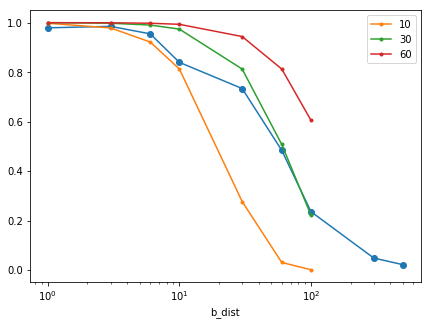

In [53]:
import matplotlib.pyplot as plt
%matplotlib inline


fig, ax = plt.subplots(1, 1, figsize = (7, 5))

np.power(10, df_disc['mean']).plot(marker = 'o', ax = ax)
np.power(10, df_cont).T.plot(marker = '.', ax = ax)
plt.xscale('log')

# for b in range(B):
#     ax.axhline(np.log10(sum((indu_p['CAPACITY']/indu_p['CAPACITY'].sum())**2)) - np.log10(4*b), linestyle = '--')


In [13]:
# indu_p.groupby(['STATE','COUNTY']).count().sample(15)

In [14]:
OR = gpd.read_file('NG_point_2.shp')
OR.crs = {'init': 'epsg:4326'}
OR = OR.merge(state_ref[['STATE', 'STATEFP']])
OR = gpd.sjoin(OR, gdf, op='within')

OR['TOTAL_Mbpd'] = OR['CAPACITY']

OSError: no such file or directory: 'NG_point_2.shp'

In [ ]:
OR = gpd.read_file('U.S._Petroleum_Refineries/U.S._Petroleum_Refineries.shp')#.merge(state_ref[['STATE', 'STATEFP']])
OR = gpd.sjoin(OR, gdf, op='within')

OR['TOTAL_Mbpd'] = OR[['AD_Mbpd','VDist_Mbpd','CaDis_Mbpd','VRedu_Mbpd','CaRef_Mbpd','Isal_Mbpd','HDS_Mbpd','Cokin_Mbpd','Asph_Mbpd']].sum(1)

In [ ]:
plt.hist(np.sqrt(counties.ALAND), 300)
plt.xlim(0, 100000)
plt.show()

# Typical county size of 40x40km. That is .36 in latitude and .42 in long, approx.

In [ ]:
industry_p = NG[['CAPACITY', 'STATE', 'COUNTY', 'ALAND', 'AREA_FIPS', 'geometry']].reset_index(drop = True)#[['COUNTY','ALAND']].drop_duplicates().sort_values(by = 'ALAND')

In [ ]:
industry_q = OR[['TOTAL_Mbpd', 'ALAND', 'AREA_FIPS', 'geometry']].reset_index(drop = True)

In [ ]:
df = pd.concat([industry_p.groupby('AREA_FIPS')[['CAPACITY']].sum(), 
           industry_q.groupby('AREA_FIPS')[['TOTAL_Mbpd']].sum()], axis = 1)

In [ ]:
import numpy as np
log_df = np.log10(df/df.sum()).dropna()
log_df.plot(x = 'TOTAL_Mbpd', y = 'CAPACITY', marker = 'o', linewidth = 0)

In [ ]:
industry_p['x'] = [p.x for p in industry_p.geometry]
industry_p['y'] = [p.y for p in industry_p.geometry]
industry_p['b'] = 1
industry_p.plot(markersize = 'CAPACITY', alpha = .1)
plt.xlim(-125, -75)
plt.ylim(25, 50)

industry_q['x'] = [p.x for p in industry_q.geometry]
industry_q['y'] = [p.y for p in industry_q.geometry]
industry_q['b'] = 1
industry_q.plot(markersize = 'TOTAL_Mbpd', alpha = .1)
plt.xlim(-125, -75)
plt.ylim(25, 50)

In [ ]:
def flap(x, y, t, b, xm, ym):
    return t*np.exp(-np.sqrt((x-xm)**2 + (y-ym)**2)/b)/(2*b)

import matplotlib.pyplot as plt
%matplotlib inline
x = np.arange(-125, -75, 0.1)
y = np.arange(25, 50, 0.1)
xx, yy = np.meshgrid(x, y, sparse=True)


def sum_pdfs(df, x = np.arange(-125, -75, 0.1), y = np.arange(25, 50, 0.1)):
    xx, yy = np.meshgrid(x, y, sparse=True)
    z_cum = np.zeros((len(y), len(x)))
    for v in df.values:
        z = flap(xx, yy, v[0], v[1], v[2], v[3])
        z_cum = z_cum + z
    return z_cum
    
z_cump = sum_pdfs(industry_p[['CAPACITY', 'b', 'x', 'y']])
h = plt.contourf(x,y,z_cump)
plt.show()
    
z_cumq = sum_pdfs(industry_q[['TOTAL_Mbpd', 'b', 'x', 'y']])
h = plt.contourf(x,y,z_cumq)
plt.show()

h = plt.contourf(x,y,z_cump * z_cumq)
plt.show()

In [ ]:

df_norm = df
df_norm = df/df.sum()
df_norm['product'] = df_norm['TOTAL_Mbpd'] * df_norm['CAPACITY']
df_norm = df_norm.reset_index().rename(columns={'index':'AREA_FIPS'})
gpd.GeoDataFrame(df_norm.dropna().merge(gdf)).plot('product', cmap = 'gray_r')
plt.xlim(-125, -75)
plt.ylim(25, 50)
plt.show()

dot_list = []
cov_list = []
B = np.array([.1, .2, .3, .4, .5, .6, .8,  1, 1.25, 1.5, 2.2])

for b in B:
    industry_p['b'] = b
    industry_q['b'] = b

    z_cump = sum_pdfs(industry_p[['CAPACITY', 'b', 'x', 'y']])
    z_cumq = sum_pdfs(industry_q[['TOTAL_Mbpd', 'b', 'x', 'y']])
    z_cump = .5*z_cump/sum(sum(z_cump))
    z_cumq = .5*z_cumq/sum(sum(z_cumq))
    dot_list += [sum(sum(z_cump * z_cumq))] # == np.dot(z_cump.flatten(), z_cumq.flatten())
    cov_list += [np.cov(z_cump.flatten(), z_cumq.flatten())[1, 0]]
    h = plt.contourf(x,y,z_cump * z_cumq)
    plt.show()

In [ ]:
# Cov vs corr... 
# data = np.log10(np.vstack([cov_list, dot_list]).T)
# plt.scatter(x = data[:, 0], y = data[:, 1])

dot = np.vstack([B, np.log10(dot_list)]).T
# cov = np.vstack([B, np.log10(cov_list)]).T
# data = cov
# plt.scatter(x = data[:, 0], y = data[:, 1])
data = dot
plt.scatter(x = data[:, 0], y = data[:, 1])
plt.axhline(np.log10(abs(np.cov((df/df.sum()).dropna().T)[1, 0])))

# plt.xlim(0, 12)
# plt.ylim(-12, -5)



In [ ]:
# plt.plot(x = data[:, 0], y = data[:, 1])
data[:, 0]

In [ ]:
data[:, 0]